In [1]:
import scipy.io
import numpy as np
import utils
import matplotlib.pyplot as plt
import os
from numpy import linalg as LA
from scipy import signal
from scipy.linalg import toeplitz
from scipy.stats import zscore, pearsonr
from sklearn.covariance import LedoitWolf
from tqdm import tqdm
%matplotlib widget

### Prepare data and pre-extracted features

- Source of data: EEGVolume.mat -- Samantha Cohen's EEG data with 64 electrodes from 18 subjects (https://www.parralab.org/isc/EEGVolume.mat) while watching this video (https://www.parralab.org/videos/roccos_AV.mp4). The length of the video is 3m 17s.
- EEG data is preprocessed and features of the video are extracted. Both with Dmochowski's code: https://github.com/dmochow/SRC
- The features can be optical flow, contrast, luminance, and even sound envelope since in their experiment the sound is not muted. ('muFlow', 'muSqFlow', 'muTemporalContrast', 'muSqTemporalContrast', 'muLuminance', 'muSqLuminance', 'muLocalContrast', 'muSqLocalContrast', 'stdLocalContrast', 'soundEnvelope', 'soundEnvelopeDown') The features are averaged over all pixels, giving us a scalar for each frame.
- Here we use optical flow because it gives a higher correlation (in this experiment). More specifically, we extract the average magnitude of the velocity in pixels per frame. Due to the Matlab CV toolbox version compatibility issue, the codes are rewritten a bit and the generated feature vector might be slightly different from the one generated by Dmochowski's original version.

In [2]:
# Load preprocessed EEG data
EEG_data = scipy.io.loadmat('../Correlated Component Analysis/data/Prepro_EEG.mat')
X_prepro = EEG_data['X']
fsEEG = 256 # fs of EEG data
T, D, N = X_prepro.shape # T=time/number of samples, D=number of channels, N=number of subjects 

In [3]:
# Load video features
features_data = scipy.io.loadmat('../Correlated Component Analysis/data/features.mat')
fsStim = int(features_data['fsVideo']) # fs of the video 
features = np.nan_to_num(features_data['muFlow']) # feature: optical flow

In [4]:
# Downsample EEG signals such that the sample frequency equals to the fs of the video
downsampledEEG = signal.resample_poly(X_prepro, fsStim, fsEEG)
features = features[:downsampledEEG.shape[0]]
normalized_features = zscore(features) # normalize features

###  Only use the data of one subject and perform CCA

In [5]:
# Select the EEG data of one subject
EEG_of_one_sub = downsampledEEG[:,:,9]
# Length of the time filter that will be applied on the extracted features. 
# It equals to the fs of the video, meaning that we take the video signals from one second ago to the current moment into consideration.
L_timefilter = fsStim

In [6]:
n_components = 5
# Find the convolution matrix and run CCA (with all data)
conv_mtx = utils.convolution_mtx(L_timefilter, normalized_features)
corr_coe, p_value, V_A, V_B = utils.cano_corr(EEG_of_one_sub, conv_mtx, n_components=n_components)
corr_coe

array([0.29889073, 0.2208627 , 0.18162085, 0.15199748, 0.12964683])

In [7]:
filtered_EEG = EEG_of_one_sub@V_A
filtered_Sti = conv_mtx@V_B

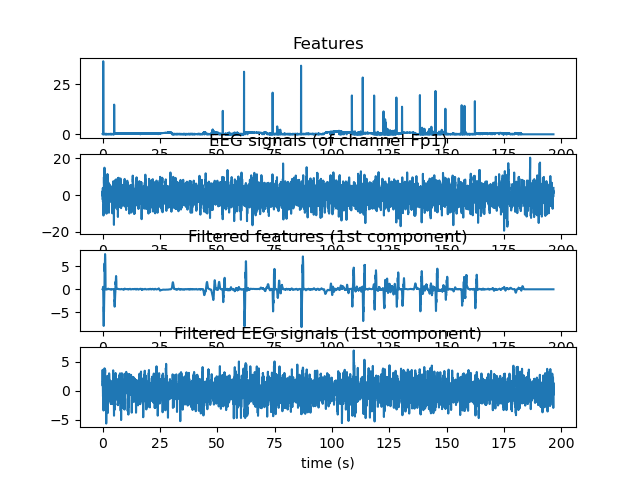

In [8]:
# Visualizations of component 1
plt.close()
compo = 1
times = np.array(range(len(features)))/fsStim
ax1 = plt.subplot(411)
ax1.plot(times, features)
ax1.title.set_text('Features')
ax2 = plt.subplot(412, sharex = ax1)
ax2.plot(times, EEG_of_one_sub[:,0])
ax2.title.set_text('EEG signals (of channel Fp1)')
ax3 = plt.subplot(413, sharex = ax1)
ax3.plot(times, filtered_Sti[:,compo-1])
ax3.title.set_text('Filtered features (1st component)')
ax4 = plt.subplot(414, sharex = ax1)
ax4.plot(times, filtered_EEG[:,compo-1])
ax4.title.set_text('Filtered EEG signals (1st component)')
ax4.set_xlabel('time (s)')
plt.show()

In [9]:
dt = times[1]-times[0]
grad = np.gradient(np.squeeze(features), dt)

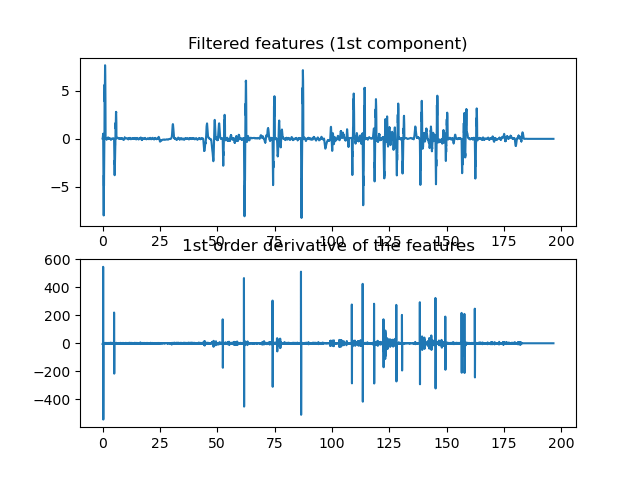

In [10]:
plt.close()
ax1 = plt.subplot(211)
ax1.plot(times, filtered_Sti[:,compo-1])
ax1.title.set_text('Filtered features (1st component)')
ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(times, grad)
ax2.title.set_text('1st order derivative of the features')
plt.show()

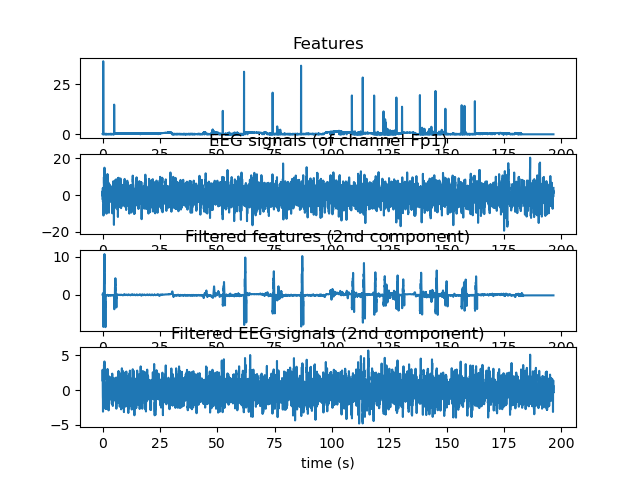

In [12]:
# Visualizations of component 2
plt.close()
compo = 2
ax1 = plt.subplot(411)
ax1.plot(times, features)
ax1.title.set_text('Features')
ax2 = plt.subplot(412, sharex = ax1)
ax2.plot(times, EEG_of_one_sub[:,0])
ax2.title.set_text('EEG signals (of channel Fp1)')
ax3 = plt.subplot(413, sharex = ax1)
ax3.plot(times, filtered_Sti[:,compo-1])
ax3.title.set_text('Filtered features (2nd component)')
ax4 = plt.subplot(414, sharex = ax1)
ax4.plot(times, filtered_EEG[:,compo-1])
ax4.title.set_text('Filtered EEG signals (2nd component)')
ax4.set_xlabel('time (s)')
plt.show()

In [13]:
grad_grad = np.gradient(grad, dt)

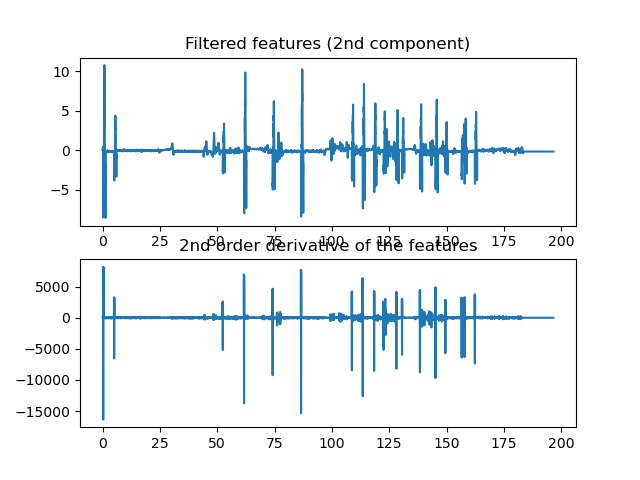

In [14]:
plt.close()
ax1 = plt.subplot(211)
ax1.plot(times, filtered_Sti[:,compo-1])
ax1.title.set_text('Filtered features (2nd component)')
ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(times, grad_grad)
ax2.title.set_text('2nd order derivative of the features')
plt.show()

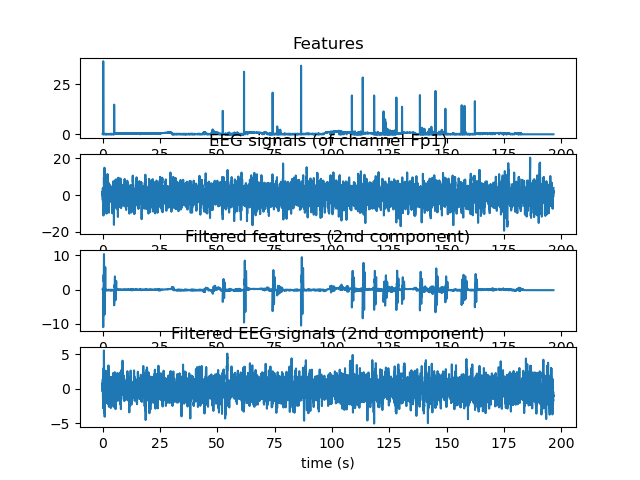

In [15]:
# Visualizations of component 2
plt.close()
compo = 3
ax1 = plt.subplot(411)
ax1.plot(times, features)
ax1.title.set_text('Features')
ax2 = plt.subplot(412, sharex = ax1)
ax2.plot(times, EEG_of_one_sub[:,0])
ax2.title.set_text('EEG signals (of channel Fp1)')
ax3 = plt.subplot(413, sharex = ax1)
ax3.plot(times, filtered_Sti[:,compo-1])
ax3.title.set_text('Filtered features (2nd component)')
ax4 = plt.subplot(414, sharex = ax1)
ax4.plot(times, filtered_EEG[:,compo-1])
ax4.title.set_text('Filtered EEG signals (2nd component)')
ax4.set_xlabel('time (s)')
plt.show()

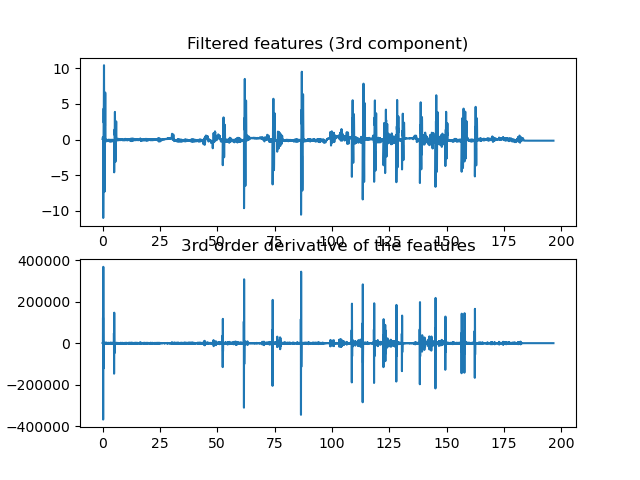

In [18]:
grad_3= np.gradient(grad_grad, dt)
plt.close()
ax1 = plt.subplot(211)
ax1.plot(times, filtered_Sti[:,compo-1])
ax1.title.set_text('Filtered features (3rd component)')
ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(times, grad_3)
ax2.title.set_text('3rd order derivative of the features')
plt.show()

#### Equivalence of CCA and GCCA when there are only two datasets
- A new function `GCCA_multi_modal` is added. It does not assume the input is pure EEG data of different subjects. The input can be a list of data of different modalities such as EEG data, video features, sound envelopes ... And it can also handle the case when the video feature is not a vector but a matrix, as long as the temporal/spatial/temporal-spatial filter is properly defined.
- Here we verify that with only two datasets (EEG data of one subject and stimulus features), the results of CCA and GCCA are the same.

In [ ]:
datalist = [EEG_of_one_sub, conv_mtx]
_, W = utils.GCCA_multi_modal(datalist, n_components, regularization=None)
W_EEG = W[:D,:]
W_Stim = W[D:D+L_timefilter,:]

In [ ]:
EEG_trans = EEG_of_one_sub@W_EEG
Stim_trans = conv_mtx@W_Stim
corr_pvalue = [pearsonr(EEG_trans[:,k], Stim_trans[:,k]) for k in range(n_components)]
corr_coe = np.array([corr_pvalue[k][0] for k in range(n_components)])
corr_coe

#### Cross-Validation

10-fold cross-validation. Take the average of the results with different folds being test sets.

In [ ]:
fold = 10
corr_train = np.zeros((fold, n_components))
corr_test = np.zeros((fold, n_components))
for idx in range(fold):
    EEG_train, EEG_test, Sti_train, Sti_test = utils.split(EEG_of_one_sub, normalized_features, fold=fold, fold_idx=idx+1)
    conv_mtx_train = utils.convolution_mtx(L_timefilter, Sti_train)
    corr_train[idx,:], p_value_train, V_A_train, V_B_train = utils.cano_corr(EEG_train, conv_mtx_train, n_components=n_components)
    conv_mtx_test = utils.convolution_mtx(L_timefilter, Sti_test)
    corr_test[idx,:], p_value_test, _, _ = utils.cano_corr(EEG_test, conv_mtx_test, n_components=n_components, V_A=V_A_train, V_B=V_B_train)

In [ ]:
corr_train

In [ ]:
corr_test

The performance is quite dependent on which fold is the test set.

In [ ]:
np.average(corr_train, axis=0)

In [ ]:
np.average(corr_test, axis=0)

### Make use of all data using GCCA

Feed all the EEG data and the convolution matrix of the features into GCCA. Returned weight vector can be decomposed as the weights of spatial filters of different subjects, and the weights of the time filter of extracted features.

In [ ]:
datalist = [downsampledEEG, conv_mtx]
_, W = utils.GCCA_multi_modal(datalist, n_components, regularization='lwcov')
W_EEG = W[:N*D,:]
W_EEG_stack = np.reshape(W_EEG, (N,D,-1))
W_EEG_stack = np.transpose(W_EEG_stack, [1,0,2]) # W: D*N*n_components
W_Stim = W[N*D:N*D+L_timefilter,:]
Wlist = [W_EEG_stack, W_Stim]

In [ ]:
avg_corr = utils.avg_corr_coe_multi_modal(datalist, Wlist, n_components=5)
avg_corr

#### Cross-Validation

In [ ]:
fold = 10
cv_n_components = 5
corr_train = np.zeros((fold, cv_n_components))
corr_test = np.zeros_like(corr_train)
for i in range(fold):
    EEG_train, EEG_test, Sti_train, Sti_test = utils.split(downsampledEEG, normalized_features, fold=fold, fold_idx=i+1)
    _, W_train = utils.GCCA_multi_modal([EEG_train, Sti_train], cv_n_components, regularization='lwcov')
    W_EEG_train = W_train[:N*D,:]
    W_EEG_stack_train = np.reshape(W_EEG_train, (N,D,-1))
    W_EEG_stack_train = np.transpose(W_EEG_stack_train, [1,0,2]) # W: D*N*n_components
    W_Stim_train = W_train[N*D:N*D+L_timefilter,:]
    Wlist_train = [W_EEG_stack_train, W_Stim_train]
    corr_train[i,:] = utils.avg_corr_coe_multi_modal([EEG_train, Sti_train], Wlist_train, n_components=5)
    corr_test[i,:] = utils.avg_corr_coe_multi_modal([EEG_test, Sti_test], Wlist_train, n_components=5)


In [ ]:
corr_train

In [ ]:
corr_test

In [ ]:
np.average(corr_train, axis=0)

In [ ]:
np.average(corr_test, axis=0)

- We can observe a large drop of correlation coefficients for unseen data, indicating the amount of data is insufficient. (The length of data is 3m 17s, and it is downsampled to 30 Hz.)
- The correlation of the first component of the last fold is very low (8.29320096e-05). It probably because the last 15 seconds of the video is all black. Then we are basically finding the correlation of the background EEG.

#### If we do not include features

- The result could be an indication of the quality of the features. Good features may guide the algorithm to do better EEG enhancement and thus lead to higher correlation. Bad features will drag the correlation down.
- Also if features are not included, then we can compare the results with the ones when EEG data is not downsampled and see how downsampling will affect the final result.

In [ ]:
fold = 10
corr_train = np.zeros((fold, cv_n_components))
corr_test = np.zeros_like(corr_train)
X_downsampled = downsampledEEG
T, D, N = X_downsampled.shape
for i in range(fold):
    len_test = T // fold
    X_test = X_downsampled[len_test*i:len_test*(i+1),:,:]
    X_train = np.delete(X_downsampled, range(len_test*i, len_test*(i+1)), axis=0)
    _, W_train, _ = utils.GCCA(X_train, n_components=n_components, regularization='lwcov')
    corr_train[i,:] = utils.avg_corr_coe(X_train, W_train, N, n_components=n_components)
    corr_test[i,:] = utils.avg_corr_coe(X_test, W_train, N, n_components=n_components)

In [ ]:
np.average(corr_train, axis=0)

In [ ]:
np.average(corr_test, axis=0)

- Slightly higher than including stimulus. 
- For reference, the results when EEG is not downsampled are:

    Training set: array([0.12882401, 0.12098105, 0.11829638, 0.11620297, 0.11211726])

    Test set: array([0.01916707, 0.00462971, 0.0070183 , 0.01117539, 0.00070067])

#### Do not include features and compare GCCA with correlated component analysis

In [ ]:
fold = 10
ISC_train = np.zeros((fold, cv_n_components))
ISC_test = np.zeros_like(ISC_train)
X_downsampled = downsampledEEG
T, D, N = X_downsampled.shape
for i in range(fold):
    len_test = T // fold
    X_test = X_downsampled[len_test*i:len_test*(i+1),:,:]
    X_train = np.delete(X_downsampled, range(len_test*i, len_test*(i+1)), axis=0)
    ISC_train[i,:], W_train = utils.corr_component(X_train, n_components=n_components)
    ISC_test[i,:], _ = utils.corr_component(X_test, n_components=n_components, W_train=W_train)

In [ ]:
np.mean(ISC_train, axis=0)

In [ ]:
np.mean(ISC_test, axis=0)

- The overfitting problem is suppressed compared to GCCA. And the performance on the test set is even better.
- For reference, the results when EEG is not downsampled are:

    Training set: array([0.05022358, 0.02988394, 0.02490273, 0.01870672, 0.01760152])

    Test set: array([0.04280363,  0.02148039,  0.01509772, -0.00111595,  0.00240869])
    
    

Note: In both GCCA and correlated component analysis, results of downsampled data are better. Can't draw any conclusion yet with this small amount of data.